In [47]:
from util.util import load_data_percentage, CustomDataset, DataLoader
from model.AttentionResNet56 import AttentionResNet56
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from model.AttentionResNet56 import AttentionResNet56
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from util.util import SpecDataset, create_data_loaders
import datetime

now = datetime.datetime.now()

# Format the current time as YYYY_MM_DD_HH_MM_SS
current_time = now.strftime("%Y_%m_%d_%H_%M_%S")

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# Load 100% of the data
X, Y, Z = load_data_percentage('./data/X_toy.npy', './data/Y_toy.npy', './data/Z_toy.npy', percentage=100) 
# X is of shape (18480, 32768, 2)
# Y is of shape (18480, 32768, 1)
# Z is of shape (18480, 1, 2)

config = {
    'model_type': 'resnet34',
    'current_time': current_time,
    'epoch': 250,
    'batch_size': 32,
    'cuda_device': torch.device("cuda:3")
}

dataset = SpecDataset(X, Y, Z, config)

In [31]:
from model.ResNet34 import resnet34_1d
import torch
from util.util import load_data_percentage, CustomDataset
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch

model = resnet34_1d()

In [50]:
import torch
from torch.utils.data import DataLoader, Subset
import os

device = torch.device("cuda:3")
model = resnet34_1d()
model.to(device)
num_epochs = 1
best_val_loss = float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Ensure directories exist
os.makedirs('./log', exist_ok=True)
os.makedirs('./weights', exist_ok=True)
criterion = nn.MSELoss()

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=32)

with open(f"./log/{config['current_time']}_{config['model_type']}_{config['epoch']}.txt", "a") as log_file:
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (x, _, z) in enumerate(train_loader):
            x, z = x.to(device), z.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, z)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _, z in val_loader:
                x, z = x.to(device), z.to(device)
                outputs = model(x)
                loss = criterion(outputs, z)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)

        # Test
        test_loss = 0
        with torch.no_grad():
            for x, _, z in test_loader:
                x, z = x.to(device), z.to(device)
                outputs = model(x)
                loss = criterion(outputs, z)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
        
        # Log the losses of each epoch to the file
        log_file.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}\n')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_name = f"./weights/{config['current_time']}_{config['model_type']}_best.pth"
            torch.save(model.state_dict(), best_model_name)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

print("Training finished!")

# Save the last model
last_model_name = f"./weights/{config['current_time']}_{config['model_type']}_last.pth"
torch.save(model.state_dict(), last_model_name)
print(f"Saved last model")

# Final evaluation
model.eval()
with torch.no_grad():
    final_test_loss = 0
    for x, _, z in test_loader:
        x, z = x.to(device), z.to(device)
        outputs = model(x)
        loss = criterion(outputs, z)
        final_test_loss += loss.item()
    
    avg_final_test_loss = final_test_loss / len(test_loader)
    print(f"Final Test Loss: {avg_final_test_loss:.4f}")


Epoch [1/1], Train Loss: 9854.8701, Val Loss: 14919.6543, Test Loss: 7804.5884
Saved best model with validation loss: 14919.6543
Training finished!
Saved last model
Final Test Loss: 7804.5884


Basic Statistics for X:
Mean: 0.5226427223412891
Standard Deviation: 31.185519447756885
Min: -2286.592658
Max: 2404.451815
Shape: (184, 32768, 2)
------------------------------
Basic Statistics for Z:
Mean: 91.20013417218478
Standard Deviation: 118.58104807872992
Min: -38.48631994407106
Max: 365.679827614597
Shape: (184, 1, 2)
------------------------------


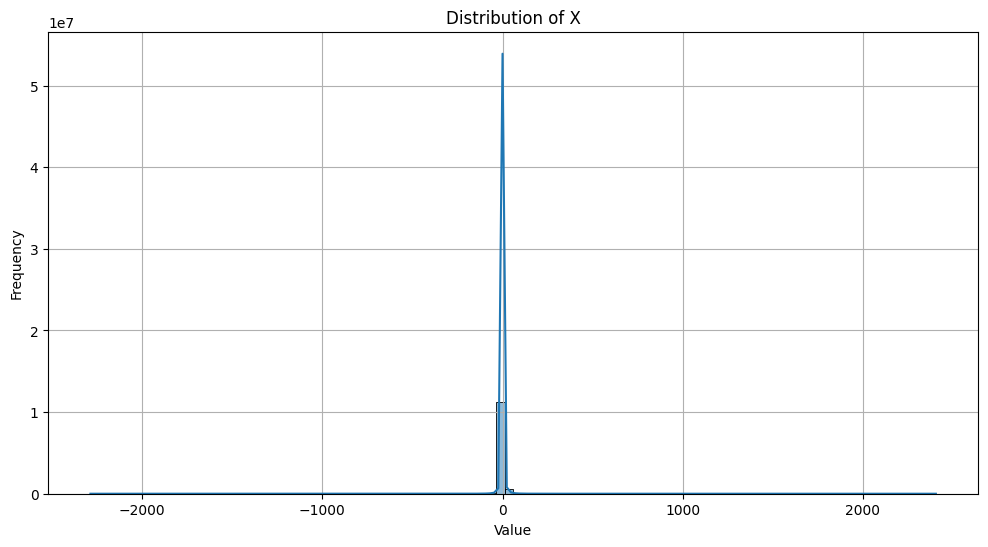

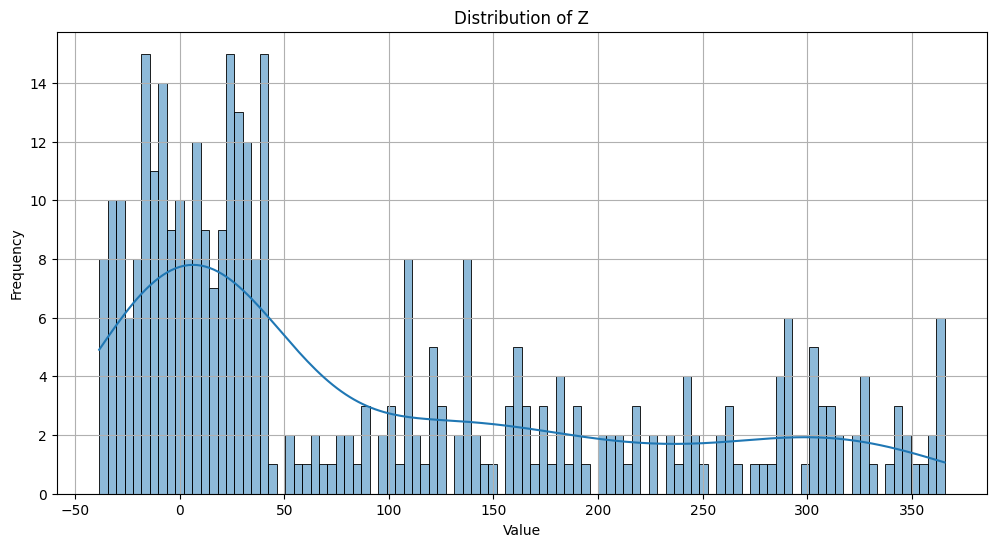

: 

In [5]:
# Basic Statistics for X and Z
def basic_statistics(data, name):
    print(f"Basic Statistics for {name}:")
    print(f"Mean: {np.mean(data)}")
    print(f"Standard Deviation: {np.std(data)}")
    print(f"Min: {np.min(data)}")
    print(f"Max: {np.max(data)}")
    print(f"Shape: {data.shape}")
    print("-" * 30)

# Analysis
basic_statistics(X, "X")
basic_statistics(Z, "Z")

# Visualizing the distribution of X (flatten for easier plotting)
plt.figure(figsize=(12, 6))
sns.histplot(X.flatten(), bins=100, kde=True)
plt.title('Distribution of X')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Visualizing the distribution of Z
plt.figure(figsize=(12, 6))
sns.histplot(Z.flatten(), bins=100, kde=True)
plt.title('Distribution of Z')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Correlation analysis
# For Z, we need to reshape to 2D to calculate correlation
Z_reshaped = Z.reshape(Z.shape[0], Z.shape[2])  # Shape: (18480, 2)
correlation_matrix = np.corrcoef(X.reshape(X.shape[0], -1), Z_reshaped, rowvar=False)

# Displaying the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix between X and Z')
plt.xlabel('Features of X and Z')
plt.ylabel('Features of X and Z')
plt.grid()
plt.show()

# PCA for X
pca = PCA(n_components=2)  # Change n_components as needed
X_reshaped = X.reshape(X.shape[0], -1)  # Flatten for PCA
X_pca = pca.fit_transform(X_reshaped)

# Explained variance
print("Explained Variance Ratio by PCA Components:")
print(pca.explained_variance_ratio_)

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
X, Y, Z = load_data_percentage('./data/X.npy', './data/Y.npy', './data/Z.npy', percentage=100)

# Check for missing values
print(np.isnan(X).any(), np.isnan(Y).any(), np.isnan(Z).any())

# Visualize time series data
plt.plot(X[0, :, 0])
plt.plot(Y[0, :, 0])
plt.show()

# Visualize feature distributions
plt.hist(X[:, :, 0].flatten(), bins=50)
plt.show()

# Calculate correlation matrix
corr_matrix = np.corrcoef(Z.flatten(), X.reshape(-1, 2).T.flatten())
print(corr_matrix)

In [3]:
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
input_shape = (X.shape[1], X.shape[2])
model = AttentionResNet56(input_shape)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x, y, z = batch
        x = x.to(device)
        z = z.to(device)
        z = z.to(device).unsqueeze(2)
        
        optimizer.zero_grad()
        output = model(x)
        mse_loss = nn.MSELoss()
        loss = mse_loss(output, z)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed!")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")

# Evaluation
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch in dataloader:
        x, y, z = batch
        x = x.to(device)
        z = z.to(device).unsqueeze(2)
        
        output = model(x)
        loss = mse_loss(output, z)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Evaluation Loss: {avg_loss:.4f}")

# Example prediction
sample_input = X[0:1]
sample_input_tensor = torch.from_numpy(sample_input).float().permute(0, 2, 1).to(device)
with torch.no_grad():
    prediction = model(sample_input_tensor)
    print(f"Sample prediction: {prediction.cpu().numpy()}")
    print(f"Actual value: {Z[0]}")


torch.save(model.state_dict(), 'weights/10.pth')


Epoch [1/20], Loss: 3149.3430
Epoch [2/20], Loss: 1083.8011
Epoch [3/20], Loss: 622.4749
Epoch [4/20], Loss: 614.9785
Epoch [5/20], Loss: 448.5938
Epoch [6/20], Loss: 372.1900
Epoch [7/20], Loss: 379.7546
Epoch [8/20], Loss: 304.2864
Epoch [9/20], Loss: 336.3487
Epoch [10/20], Loss: 225.2593
Epoch [11/20], Loss: 286.1391
Epoch [12/20], Loss: 208.0486
Epoch [13/20], Loss: 312.5989
Epoch [14/20], Loss: 186.0236
Epoch [15/20], Loss: 279.7806
Epoch [16/20], Loss: 201.0575
Epoch [17/20], Loss: 185.9349
Epoch [18/20], Loss: 198.2771
Epoch [19/20], Loss: 180.9272
Epoch [20/20], Loss: 165.7675
Training completed!
Evaluation Loss: 147.3260
Sample prediction: [[[172.92159  ]
  [ -1.9854114]]]
Actual value: [[172.51833696  -7.87610703]]


: 

In [8]:
from model.ResNet34 import resnet34


In [10]:
model = resnet34()
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
X, Y, Z = load_data_percentage('./data/X.npy', './data/Y.npy', './data/Z.npy', percentage=10)
dataset = CustomDataset(X, Y, Z)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = resnet34_1d().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, _, z) in enumerate(train_loader):
        x, z = x.to(device), z.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, z)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training finished!")

# Simple evaluation
model.eval()
with torch.no_grad():
    x, _, z = next(iter(train_loader))
    x, z = x.to(device), z.to(device)
    outputs = model(x)
    eval_loss = criterion(outputs, z)
    print(f"Evaluation Loss: {eval_loss.item():.4f}")

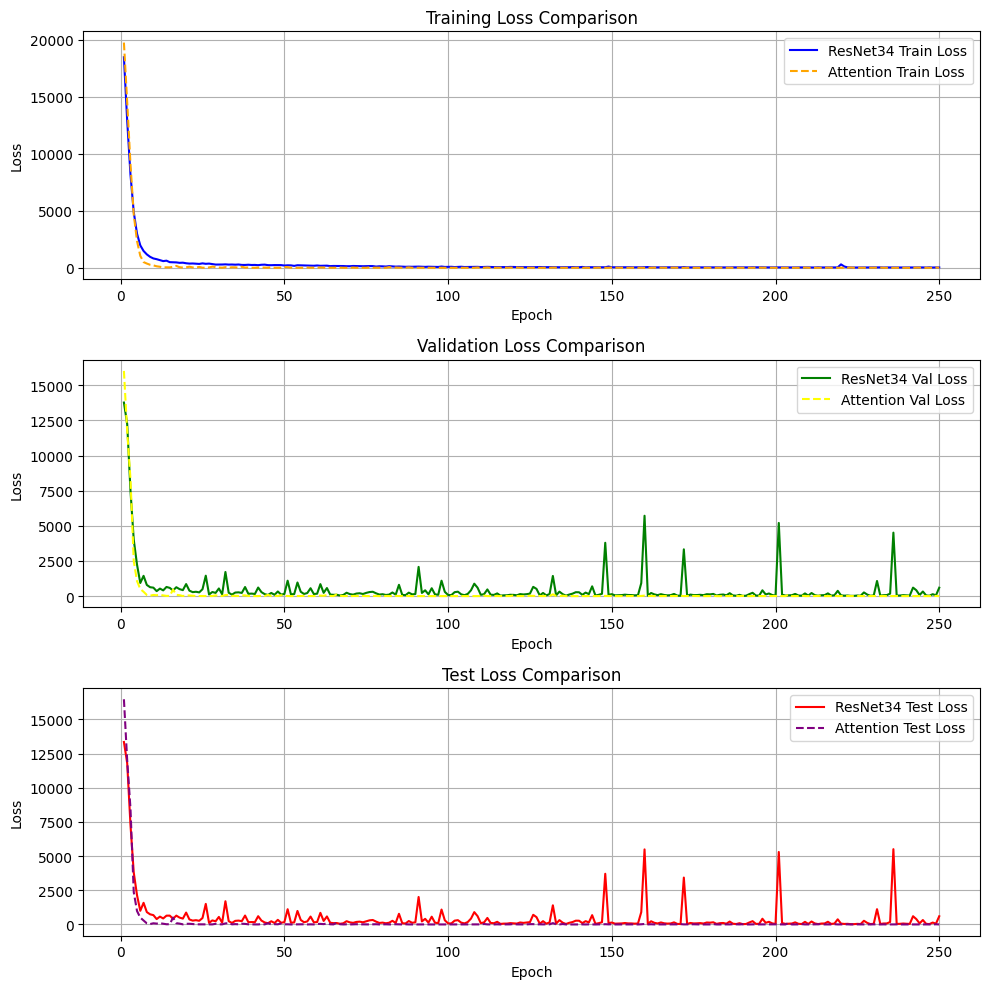

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to parse log file
def parse_log(file_path):
    data = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': []
    }
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            epoch = int(parts[0].split('[')[1].split('/')[0])
            train_loss = float(parts[1].split(': ')[1])
            val_loss = float(parts[2].split(': ')[1])
            test_loss = float(parts[3].split(': ')[1])
            
            data['epoch'].append(epoch)
            data['train_loss'].append(train_loss)
            data['val_loss'].append(val_loss)
            data['test_loss'].append(test_loss)
    
    return pd.DataFrame(data)

# Parse both log files
log_resnet34 = parse_log('log/2024_10_31_17_02_27_resnet34_250.txt')
log_resnet_attention = parse_log('log/2024_10_31_17_03_20_resnet_attention_250.txt')

# Set up subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot Train Loss
axs[0].plot(log_resnet34['epoch'], log_resnet34['train_loss'], label='ResNet34 Train Loss', color='blue')
axs[0].plot(log_resnet_attention['epoch'], log_resnet_attention['train_loss'], label='Attention Train Loss', linestyle='--', color='orange')
axs[0].set_title('Training Loss Comparison')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot Validation Loss
axs[1].plot(log_resnet34['epoch'], log_resnet34['val_loss'], label='ResNet34 Val Loss', color='green')
axs[1].plot(log_resnet_attention['epoch'], log_resnet_attention['val_loss'], label='Attention Val Loss', linestyle='--', color='yellow')
axs[1].set_title('Validation Loss Comparison')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

# Plot Test Loss
axs[2].plot(log_resnet34['epoch'], log_resnet34['test_loss'], label='ResNet34 Test Loss', color='red')
axs[2].plot(log_resnet_attention['epoch'], log_resnet_attention['test_loss'], label='Attention Test Loss', linestyle='--', color='purple')
axs[2].set_title('Test Loss Comparison')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
# plt.show()
plt.savefig("log/loss.png", dpi = 600)
